# Survival impact of InstaPrism cell-type fractions in Schildkraut HGSOC

This analysis investigates the prognostic impact of intratumoral cellular composition on survival outcomes in high-grade serous ovarian cancer (HGSOC). Using multivariable Cox proportional hazards models, we evaluate whether the abundance of adipocytes, stromal cells, immune cells, and epithelial cells within tumors is associated with overall mortality. Hazard ratios, confidence intervals, and p-values are reported for both complete-case and reduced-covariate models to assess robustness. The analysis further considers surgical variables such as bulky residual disease, allowing us to determine which tumor-intrinsic and clinical features independently predict patient survival.

**Results** 

Adipocyte abundance was a strong, independent predictor of poor survival in HGSOC, with each 10% increase in intratumoral adipocyte content raising mortality risk by about 25%, a finding consistent across statistical models. In contrast, age showed only a weak trend, while BMI, race, stromal, immune, and epithelial cell proportions had no significant impact. The only other strong predictor was bulky residual disease after surgery, which increased the hazard of death by 50%. Overall, adipocytes uniquely captured a tumor-intrinsic feature linked to worse outcomes.

In [77]:
import pandas as pd
import numpy as np
from lifelines import CoxPHFitter
from lifelines.utils import k_fold_cross_validation
from sklearn.model_selection import ParameterGrid
import numpy as np, pandas as pd
from lifelines.utils import k_fold_cross_validation
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid, KFold
import os
from sklearn.preprocessing import StandardScaler
from matplotlib_venn import venn2
import sys
from matplotlib.ticker import LogLocator, LogFormatter
import matplotlib

sys.path.insert(1, "../../")
sys.path.insert(1, "../")

import src.hp as hp

pd.set_option("display.max_rows", 100)
plt.style.use("default")

np.random.seed(88)

In [78]:
cell_types_to_use = ["Adipocytes"]  # Adipocytes, Stromal, Immune, Epithelial
complete_case = True

In [79]:
map_stage = True
remove_unknown_stage = True
remove_999_BMI = True
kaplan_meier = True
remove_BMI_treat = False

## Paths

In [80]:
base_path = os.path.dirname(os.getcwd())
meta_path = os.path.join(base_path, "input_data/metadata.xlsx")

### Formatting for below plots, etc.

In [81]:
if complete_case:
    remove_treatment = False
    remove_pts_with_unknowns = True

else:
    remove_treatment = True
    remove_pts_with_unknowns = False

In [82]:
## The order for the plots below
if remove_BMI_treat:
    desired_order = [
        "Age",
        "Race: Black",
        "Residual: < 1cm",
        "Residual: ≥ 1cm",
    ]
else:
    desired_order = [
        "Age",
        "BMI",
        "Race: Black",
        "Residual: < 1cm",
        "Residual: ≥ 1cm",
    ]
if remove_treatment:
    desired_order.remove("Residual: < 1cm")
    desired_order.remove("Residual: ≥ 1cm")

desired_order

['Age', 'BMI', 'Race: Black', 'Residual: < 1cm', 'Residual: ≥ 1cm']

In [83]:
# continuous covariates to keep “as is”
if remove_BMI_treat:
    cont_cols = ["Age"]
else:
    cont_cols = ["Age", "BMI"]

## Load InstaPrism cell-fraction tables (processed) and metadata

Proportions

In [84]:
props = pd.read_csv(
    os.path.join(base_path, "input_data/proportions_sch.csv"), index_col=0
)
props

,SampleID,Plasma cells,B cells,Endothelial cells,T cells,Monocytes,Fibroblasts,NK cells,Epithelial cells,DC,pDC,ILC,Macrophages,Mast cells,Erythroid,Adipocytes,Dataset,suid,ID
0,18341X10,4.919765e-49,0.052767,0.029870,1.833554e-26,1.727071e-60,7.074672e-105,8.375315e-10,0.746341,1.257780e-139,3.590420e-30,2.867046e-78,1.185148e-02,1.538137e-57,0.0,0.159171,SchildkrautB,18341X10,45369
1,18341X12,9.351753e-92,0.027159,0.011666,5.972580e-66,2.258210e-157,8.180384e-107,8.135649e-61,0.848153,3.276474e-210,2.054386e-103,1.247009e-85,2.337775e-128,1.452291e-115,0.0,0.113022,SchildkrautB,18341X12,47261
2,18341X13,6.998799e-32,0.014663,0.041547,1.004614e-23,3.232466e-34,1.225464e-02,9.550579e-19,0.819028,1.104356e-115,3.157063e-69,7.123720e-41,2.994756e-02,1.850941e-63,0.0,0.082561,SchildkrautB,18341X13,47791
3,18341X14,2.410384e-97,0.162711,0.022343,2.056824e-52,5.485488e-33,2.751866e-120,7.904174e-39,0.642545,4.774011e-154,1.326676e-75,2.334007e-77,1.516542e-02,1.488048e-80,0.0,0.157235,SchildkrautB,18341X14,47916
4,18341X15,3.439318e-76,0.050581,0.055021,5.687981e-28,5.314872e-52,8.961526e-02,2.919113e-22,0.649017,7.625379e-122,1.873123e-52,3.487465e-81,1.419715e-02,4.216693e-41,0.0,0.141568,SchildkrautB,18341X15,48002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
583,20160X95,1.442627e-108,0.136578,0.014420,3.410104e-30,3.267116e-82,7.666630e-23,1.501224e-35,0.710289,6.509988e-151,4.903142e-78,8.571710e-105,3.473745e-03,5.671299e-79,0.0,0.135240,SchildkrautW,20160X95,47786
584,20160X96,1.359916e-92,0.190881,0.017396,5.383974e-33,2.734703e-86,1.156925e-02,1.945285e-24,0.592805,1.063562e-147,5.374615e-82,8.551669e-96,1.270617e-02,4.370517e-04,0.0,0.174205,SchildkrautW,20160X96,47903
585,20160X97,7.862780e-79,0.102850,0.053137,8.610293e-03,1.076987e-46,4.237821e-02,1.467756e-05,0.656171,3.397744e-114,5.089409e-39,1.625064e-79,2.253584e-02,9.865474e-05,0.0,0.114204,SchildkrautW,20160X97,47926
586,20160X98,1.245316e-60,0.127050,0.034344,1.345753e-16,5.846372e-04,2.787547e-02,2.169830e-04,0.673204,4.422809e-95,4.998254e-48,3.881728e-35,5.796692e-04,4.236351e-47,0.0,0.136146,SchildkrautW,20160X98,47937


In [85]:
## Which cell types to use
if cell_types_to_use == ["Immune"]:
    cell_types_to_use_grouped = [
        "B cells",
        "Mast cells",
        "T cells",
        "Monocytes",
        "Plasma cells",
        "NK cells",
        "DC",
        "pDC",
        "Macrophages",
        "ILC",
    ]
    desired_order = desired_order + ["Immune"]

elif cell_types_to_use == ["Stromal"]:
    cell_types_to_use_grouped = ["Fibroblasts", "Endothelial cells"]
    desired_order = desired_order + ["Stromal"]

elif cell_types_to_use == ["Adipocytes"]:
    cell_types_to_use_grouped = ["Adipocytes"]
    desired_order = desired_order + ["Adipocytes"]

elif cell_types_to_use == ["Epithelial"]:
    props["Epithelial"] = props["Epithelial cells"]
    cell_types_to_use_grouped = ["Epithelial"]
    desired_order = desired_order + ["Epithelial"]

props[cell_types_to_use[0]] = props[cell_types_to_use_grouped].sum(axis=1)

props[cell_types_to_use[0]] = props[cell_types_to_use[0]] * 10

props

,SampleID,Plasma cells,B cells,Endothelial cells,T cells,Monocytes,Fibroblasts,NK cells,Epithelial cells,DC,pDC,ILC,Macrophages,Mast cells,Erythroid,Adipocytes,Dataset,suid,ID
0,18341X10,4.919765e-49,0.052767,0.029870,1.833554e-26,1.727071e-60,7.074672e-105,8.375315e-10,0.746341,1.257780e-139,3.590420e-30,2.867046e-78,1.185148e-02,1.538137e-57,0.0,1.591710,SchildkrautB,18341X10,45369
1,18341X12,9.351753e-92,0.027159,0.011666,5.972580e-66,2.258210e-157,8.180384e-107,8.135649e-61,0.848153,3.276474e-210,2.054386e-103,1.247009e-85,2.337775e-128,1.452291e-115,0.0,1.130216,SchildkrautB,18341X12,47261
2,18341X13,6.998799e-32,0.014663,0.041547,1.004614e-23,3.232466e-34,1.225464e-02,9.550579e-19,0.819028,1.104356e-115,3.157063e-69,7.123720e-41,2.994756e-02,1.850941e-63,0.0,0.825608,SchildkrautB,18341X13,47791
3,18341X14,2.410384e-97,0.162711,0.022343,2.056824e-52,5.485488e-33,2.751866e-120,7.904174e-39,0.642545,4.774011e-154,1.326676e-75,2.334007e-77,1.516542e-02,1.488048e-80,0.0,1.572353,SchildkrautB,18341X14,47916
4,18341X15,3.439318e-76,0.050581,0.055021,5.687981e-28,5.314872e-52,8.961526e-02,2.919113e-22,0.649017,7.625379e-122,1.873123e-52,3.487465e-81,1.419715e-02,4.216693e-41,0.0,1.415675,SchildkrautB,18341X15,48002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
583,20160X95,1.442627e-108,0.136578,0.014420,3.410104e-30,3.267116e-82,7.666630e-23,1.501224e-35,0.710289,6.509988e-151,4.903142e-78,8.571710e-105,3.473745e-03,5.671299e-79,0.0,1.352398,SchildkrautW,20160X95,47786
584,20160X96,1.359916e-92,0.190881,0.017396,5.383974e-33,2.734703e-86,1.156925e-02,1.945285e-24,0.592805,1.063562e-147,5.374615e-82,8.551669e-96,1.270617e-02,4.370517e-04,0.0,1.742051,SchildkrautW,20160X96,47903
585,20160X97,7.862780e-79,0.102850,0.053137,8.610293e-03,1.076987e-46,4.237821e-02,1.467756e-05,0.656171,3.397744e-114,5.089409e-39,1.625064e-79,2.253584e-02,9.865474e-05,0.0,1.142044,SchildkrautW,20160X97,47926
586,20160X98,1.245316e-60,0.127050,0.034344,1.345753e-16,5.846372e-04,2.787547e-02,2.169830e-04,0.673204,4.422809e-95,4.998254e-48,3.881728e-35,5.796692e-04,4.236351e-47,0.0,1.361460,SchildkrautW,20160X98,47937


In [86]:
# Keep only the columns of interest
keep_cols = cell_types_to_use + ["SampleID", "Dataset", "ID"]
props = props[keep_cols]

## Merge, encode categorical covariates

### Build the analysis table  (clinical + cell fractions)


In [87]:
renaming = hp.get_variable_renaming()
renaming.pop("tissue", None)

'Tissue'

Metadata

In [88]:
meta_full = (
    pd.read_excel(meta_path, sheet_name=0)
    .rename(columns=str.strip)
    .rename(columns=renaming)
)

meta_full = meta_full[renaming.values()]
meta_full["Residual"].value_counts(dropna=False)

Residual
NaN    288
1.0    110
2.0     99
4.0     52
3.0     39
Name: count, dtype: int64

In [89]:
## Importing and renaming metadata

# ------------------------------ clinical columns -----------------
meta_full = (
    pd.read_excel(meta_path, sheet_name=0)
    .rename(columns=str.strip)
    .rename(columns=renaming)
)

meta_full = meta_full[renaming.values()]

meta_full["Stage"] = pd.to_numeric(meta_full["Stage"], errors="coerce")

meta_full["Event"] = meta_full["Event"].astype(int)
meta_full["Time-Days"] = meta_full["Time_Yrs"] * 365.22

#Removing patients that received adj. therapy in the complete case model
if complete_case:
    to_rm_adjtx = meta_full[meta_full["AdjTx"] == 2]["ID"].unique().tolist()
    meta_full = meta_full[~meta_full["ID"].isin(to_rm_adjtx)]
    props = props[~props["ID"].isin(to_rm_adjtx)]
    
meta_full

,ID,Age,Event,Time_Yrs,Stage,Race,Debulk,Hispanic,BMI,NeoTx,AdjTx,Residual,Time-Days
0,40143,63,1,8.739220,3,1,2.0,2,23.218229,2.0,1.0,4.0,3191.737824
1,41377,54,1,1.180014,3,1,2.0,2,17.428942,2.0,NaN,3.0,430.964599
2,41387,55,1,11.983573,3,2,1.0,2,45.470350,2.0,1.0,2.0,4376.640495
3,41391,60,1,4.993840,3,1,2.0,2,31.340800,2.0,NaN,3.0,1823.850185
4,41435,59,1,4.057495,3,1,NaN,2,23.922658,NaN,NaN,NaN,1481.878275
...,...,...,...,...,...,...,...,...,...,...,...,...,...
583,310266,40,0,9.702186,3,2,NaN,2,28.349557,NaN,NaN,NaN,3543.432295
584,320012,66,0,11.767760,3,2,2.0,2,37.677475,2.0,1.0,4.0,4297.821147
585,320025,60,1,6.827869,3,2,2.0,2,38.740537,2.0,1.0,3.0,2493.674262
586,320043,57,1,1.553425,3,2,2.0,2,19.854802,2.0,1.0,4.0,567.341754


Filtering samples

In [90]:
# Mapping unknown residual treatment size to >=1cm
meta_full["Residual"] = meta_full["Residual"].replace(4.0, 3.0) ## Making the residual disaease unknow size

if remove_unknown_stage:
    first = meta_full.shape[0]
    meta_full = meta_full[meta_full["Stage"] != 9]
    print("Removed for unknown stage: ", first - meta_full.shape[0])

if remove_999_BMI:
    first = meta_full.shape[0]
    meta_full = meta_full[meta_full["BMI"] != 999]
    print("Removed for BMI 999: ", first - meta_full.shape[0])

# In no case we'd use Hispanic variable:
meta_full.drop(columns=["Hispanic"], inplace=True)

# We are removing debulking treatment that includes CA125.
meta_full.drop(columns=["Debulk"], inplace=True)
meta_full.drop(columns=["NeoTx"], inplace=True)

meta_full

Removed for unknown stage:  9
Removed for BMI 999:  13


,ID,Age,Event,Time_Yrs,Stage,Race,BMI,AdjTx,Residual,Time-Days
0,40143,63,1,8.739220,3,1,23.218229,1.0,3.0,3191.737824
1,41377,54,1,1.180014,3,1,17.428942,NaN,3.0,430.964599
2,41387,55,1,11.983573,3,2,45.470350,1.0,2.0,4376.640495
3,41391,60,1,4.993840,3,1,31.340800,NaN,3.0,1823.850185
4,41435,59,1,4.057495,3,1,23.922658,NaN,NaN,1481.878275
...,...,...,...,...,...,...,...,...,...,...
583,310266,40,0,9.702186,3,2,28.349557,NaN,NaN,3543.432295
584,320012,66,0,11.767760,3,2,37.677475,1.0,3.0,4297.821147
585,320025,60,1,6.827869,3,2,38.740537,1.0,3.0,2493.674262
586,320043,57,1,1.553425,3,2,19.854802,1.0,3.0,567.341754


In [91]:
summary_black = hp.meta_summary_table(meta_full[meta_full.Race == 2])
summary_black

,Clinical Variable,Category/Statistic,Value
0,Race,Race = 2,256.00
1,Age at Diagnosis,N,256.00
2,Age at Diagnosis,Mean,57.92
3,Age at Diagnosis,Std,9.80
4,Age at Diagnosis,Min,35.00
5,Age at Diagnosis,Max,78.00
6,Vital Status,Deceased,192.00
7,Vital Status,Alive/Censored,64.00
8,Years from diagnosis to last follow up,N,256.00
9,Years from diagnosis to last follow up,Mean,5.92


In [92]:
summary_white = hp.meta_summary_table(meta_full[meta_full.Race == 1])
summary_white

,Clinical Variable,Category/Statistic,Value
0,Race,Race = 1,303.00
1,Age at Diagnosis,N,303.00
2,Age at Diagnosis,Mean,58.45
3,Age at Diagnosis,Std,9.36
4,Age at Diagnosis,Min,31.00
5,Age at Diagnosis,Max,74.00
6,Vital Status,Deceased,258.00
7,Vital Status,Alive/Censored,45.00
8,Years from diagnosis to last follow up,N,303.00
9,Years from diagnosis to last follow up,Mean,6.54


In [93]:
# If we remove treatment we only keep Race and Stage of the categoricals.
if remove_treatment:
    cat_cols = ["Stage", "Race"]
    meta_full[cat_cols] = meta_full[cat_cols].astype("category")
    meta_full.columns
else:
    cat_cols = ["Stage", "Race", "Residual"]
    meta_full[cat_cols] = meta_full[cat_cols].astype("category")
    meta_full.columns


if remove_BMI_treat:
    meta_full.drop(columns=["BMI"], inplace=True)

meta_full

,ID,Age,Event,Time_Yrs,Stage,Race,BMI,AdjTx,Residual,Time-Days
0,40143,63,1,8.739220,3,1,23.218229,1.0,3.0,3191.737824
1,41377,54,1,1.180014,3,1,17.428942,NaN,3.0,430.964599
2,41387,55,1,11.983573,3,2,45.470350,1.0,2.0,4376.640495
3,41391,60,1,4.993840,3,1,31.340800,NaN,3.0,1823.850185
4,41435,59,1,4.057495,3,1,23.922658,NaN,NaN,1481.878275
...,...,...,...,...,...,...,...,...,...,...
583,310266,40,0,9.702186,3,2,28.349557,NaN,NaN,3543.432295
584,320012,66,0,11.767760,3,2,37.677475,1.0,3.0,4297.821147
585,320025,60,1,6.827869,3,2,38.740537,1.0,3.0,2493.674262
586,320043,57,1,1.553425,3,2,19.854802,1.0,3.0,567.341754


In [94]:
# generate summary
summary_table = hp.meta_summary_table(meta_full)
print(summary_table)

                         Clinical Variable Category/Statistic   Value
0                                     Race           Race = 1  303.00
1                                     Race           Race = 2  256.00
2                         Age at Diagnosis                  N  559.00
3                         Age at Diagnosis               Mean   58.21
4                         Age at Diagnosis                Std    9.56
5                         Age at Diagnosis                Min   31.00
6                         Age at Diagnosis                Max   78.00
7                             Vital Status           Deceased  450.00
8                             Vital Status     Alive/Censored  109.00
9   Years from diagnosis to last follow up                  N  559.00
10  Years from diagnosis to last follow up               Mean    6.26
11  Years from diagnosis to last follow up                Std    4.91
12  Years from diagnosis to last follow up                Min    0.35
13  Years from diagn

In [95]:
meta_full.drop(columns=["AdjTx"], inplace=True)

In [96]:
# ------------------------------ merge meta + props ----------------------------
# every SampleID maps to a unique suid)
analysis = props.merge(meta_full, on="ID", how="inner")

print(f"Using: {analysis.shape[0]} rows, {analysis['ID'].nunique()} patients")

analysis

Using: 559 rows, 559 patients


,Adipocytes,SampleID,Dataset,ID,Age,Event,Time_Yrs,Stage,Race,BMI,Residual,Time-Days
0,1.591710,18341X10,SchildkrautB,45369,53,1,2.004107,3,2,31.110562,3.0,731.939877
1,1.130216,18341X12,SchildkrautB,47261,57,1,5.240246,3,2,29.448927,NaN,1913.842793
2,0.825608,18341X13,SchildkrautB,47791,45,1,4.396988,3,2,40.981420,NaN,1605.868090
3,1.572353,18341X14,SchildkrautB,47916,68,1,2.151951,4,2,28.928061,NaN,785.935442
4,1.415675,18341X15,SchildkrautB,48002,44,1,1.508556,3,2,24.991295,2.0,550.954743
...,...,...,...,...,...,...,...,...,...,...,...,...
554,1.352398,20160X95,SchildkrautW,47786,68,1,2.554415,3,1,31.538819,NaN,932.923367
555,1.742051,20160X96,SchildkrautW,47903,45,1,2.910335,3,1,20.410354,NaN,1062.912690
556,1.142044,20160X97,SchildkrautW,47926,52,0,14.414784,3,1,34.458370,NaN,5264.567555
557,1.361460,20160X98,SchildkrautW,47937,43,1,3.238877,3,1,20.156950,2.0,1182.902834


In [97]:
## Mapping the stage variable for stratification
if map_stage:
    stage_map = {1: 1, 2: 1, 3: 2, 4: 2}
    analysis["Stage"] = analysis.Stage.map(stage_map)

if remove_pts_with_unknowns:
    print("Going from: ", analysis.shape)
    analysis = analysis.dropna(subset=["Residual"])
    print("To: ", analysis.shape)

analysis

Going from:  (559, 12)
To:  (287, 12)


,Adipocytes,SampleID,Dataset,ID,Age,Event,Time_Yrs,Stage,Race,BMI,Residual,Time-Days
0,1.591710,18341X10,SchildkrautB,45369,53,1,2.004107,2,2,31.110562,3.0,731.939877
4,1.415675,18341X15,SchildkrautB,48002,44,1,1.508556,2,2,24.991295,2.0,550.954743
9,2.161446,18341X27,SchildkrautB,46196,67,1,4.635181,2,2,32.198190,2.0,1692.860945
17,1.816324,18341X35,SchildkrautB,47251,71,1,1.234771,2,2,23.620798,2.0,450.962957
18,1.298331,18341X38,SchildkrautB,47927,51,1,2.570842,2,2,21.873770,2.0,938.922875
...,...,...,...,...,...,...,...,...,...,...,...,...
549,1.334981,20160X90,SchildkrautW,47148,47,1,1.984942,2,1,39.153028,3.0,724.940452
550,1.665924,20160X91,SchildkrautW,47185,57,1,11.512663,2,1,43.240248,2.0,4204.654620
551,1.098901,20160X92,SchildkrautW,47226,71,1,5.577002,2,1,20.892489,2.0,2036.832690
557,1.361460,20160X98,SchildkrautW,47937,43,1,3.238877,2,1,20.156950,2.0,1182.902834


In [98]:
for col in analysis:
    print(analysis[col].value_counts(dropna=False))

Adipocytes
1.591710    1
0.921025    1
1.014397    1
0.726155    1
1.053575    1
           ..
0.961521    1
0.873030    1
1.232455    1
3.328698    1
1.484585    1
Name: count, Length: 287, dtype: int64
SampleID
18341X10     1
20160X122    1
20160X128    1
20160X127    1
20160X126    1
            ..
19291X241    1
19291X240    1
19291X24     1
19291X238    1
20160X99     1
Name: count, Length: 287, dtype: int64
Dataset
SchildkrautB    170
SchildkrautW    117
Name: count, dtype: int64
ID
45369     1
47615     1
47974     1
47959     1
47897     1
         ..
180044    1
180041    1
43568     1
180037    1
47991     1
Name: count, Length: 287, dtype: int64
Age
57    15
61    14
63    13
52    11
54    11
60    10
58    10
67    10
71    10
51    10
55    10
59     9
53     9
62     9
56     9
72     8
50     8
73     8
49     8
65     7
68     7
43     7
66     7
69     6
64     6
45     6
46     6
44     5
70     5
47     5
74     5
48     5
42     4
39     3
77     3
41     2
76     

In [99]:
if remove_treatment:
    if remove_BMI_treat:
        cols = ["Age", "Event", "Time_Yrs", "Time-Days", "Stage", "Residual"]
    else:
        cols = [
            "Age",
            "Event",
            "Time_Yrs",
            "BMI",
            "Time-Days",
            "Stage",
            "Residual",
        ]

    cat_cols = ["Race"]
    # Get dummys for categorical columns with more than 2 cats (NaN counts as category)
    dummies = pd.get_dummies(
        analysis, columns=cat_cols, drop_first=True, prefix_sep="_"
    )
    dummies.drop(columns=props.columns, inplace=True)  # remove original proportions
    dummies.drop(columns=cols, inplace=True)  # remove original proportions
    dummies

else:
    if remove_BMI_treat:
        cols = ["Age", "Event", "Time_Yrs", "Time-Days", "Stage"]
    else:
        cols = ["Age", "Event", "Time_Yrs", "BMI", "Time-Days", "Stage"]

    cat_cols = ["Residual", "Race"]
    # Get dummys for categorical columns with more than 2 cats (NaN counts as category)
    dummies = pd.get_dummies(
        analysis, columns=cat_cols, drop_first=True, prefix_sep="_"
    )
    dummies.drop(columns=props.columns, inplace=True)  # remove original proportions
    dummies.drop(columns=cols, inplace=True)  # remove original proportions
dummies

,Residual_2.0,Residual_3.0,Race_2
0,False,True,True
4,True,False,True
9,True,False,True
17,True,False,True
18,True,False,True
...,...,...,...
549,False,True,False
550,True,False,False
551,True,False,False
557,True,False,False


In [100]:
for col in dummies:
    print(dummies[col].value_counts(dropna=False))

Residual_2.0
False    192
True      95
Name: count, dtype: int64
Residual_3.0
False    200
True      87
Name: count, dtype: int64
Race_2
True     170
False    117
Name: count, dtype: int64


In [101]:
# Put together the analysis DataFrame
# (keep the original categorical columns for later use)
analysis_enc = pd.concat([analysis, dummies], axis=1)  # Columns that go into the model
cell_cols = props.columns.difference(["SampleID", "Dataset", "ID"])  # fractions
covars = cont_cols + list(dummies.columns) + list(cell_cols) + ["Stage"]

covars

['Age', 'BMI', 'Residual_2.0', 'Residual_3.0', 'Race_2', 'Adipocytes', 'Stage']

In [102]:
cox_df = analysis_enc[["Time-Days", "Event"] + covars].copy()

if "Race_2" in cox_df.columns:
    cox_df.rename(columns={"Race_2": "Race: Black"}, inplace=True)
if "Residual_3.0" in cox_df.columns:
    cox_df.rename(columns={"Residual_3.0": "Residual: ≥ 1cm"}, inplace=True)
    cox_df.rename(columns={"Residual_2.0": "Residual: < 1cm"}, inplace=True)

In [103]:
print("Design matrix:", cox_df.shape)
print("Design matrix columns:", cox_df.columns)
cox_df

Design matrix: (287, 9)
Design matrix columns: Index(['Time-Days', 'Event', 'Age', 'BMI', 'Residual: < 1cm',
       'Residual: ≥ 1cm', 'Race: Black', 'Adipocytes', 'Stage'],
      dtype='object')


,Time-Days,Event,Age,BMI,Residual: < 1cm,Residual: ≥ 1cm,Race: Black,Adipocytes,Stage
0,731.939877,1,53,31.110562,False,True,True,1.591710,2
4,550.954743,1,44,24.991295,True,False,True,1.415675,2
9,1692.860945,1,67,32.198190,True,False,True,2.161446,2
17,450.962957,1,71,23.620798,True,False,True,1.816324,2
18,938.922875,1,51,21.873770,True,False,True,1.298331,2
...,...,...,...,...,...,...,...,...,...
549,724.940452,1,47,39.153028,False,True,False,1.334981,2
550,4204.654620,1,57,43.240248,True,False,False,1.665924,2
551,2036.832690,1,71,20.892489,True,False,False,1.098901,2
557,1182.902834,1,43,20.156950,True,False,False,1.361460,2


Iteration 1: norm_delta = 4.44e-01, step_size = 0.9500, log_lik = -1044.66508, newton_decrement = 1.69e+01, seconds_since_start = 0.0
Iteration 2: norm_delta = 4.19e-02, step_size = 0.9500, log_lik = -1029.12831, newton_decrement = 2.05e-01, seconds_since_start = 0.0
Iteration 3: norm_delta = 1.91e-03, step_size = 0.9500, log_lik = -1028.92472, newton_decrement = 4.64e-04, seconds_since_start = 0.0
Iteration 4: norm_delta = 1.46e-06, step_size = 1.0000, log_lik = -1028.92425, newton_decrement = 1.91e-10, seconds_since_start = 0.0
Convergence success after 4 iterations.


<lifelines.CoxPHFitter: fitted with 287 total observations, 64 right-censored observations>
             duration col = 'Time-Days'
                event col = 'Event'
                   strata = Stage
      baseline estimation = breslow
   number of observations = 287
number of events observed = 223
   partial log-likelihood = -1028.92
         time fit was run = 2025-11-12 00:23:41 UTC

---
                 coef exp(coef)    z      p
covariate                                  
Age              0.00      1.00 0.33   0.74
BMI              0.00      1.00 0.20   0.84
Residual: < 1cm  0.28      1.32 1.55   0.12
Residual: ≥ 1cm  0.74      2.09 4.15 <0.005
Race: Black      0.11      1.12 0.72   0.47
Adipocytes       0.38      1.46 2.95 <0.005
---
Concordance = 0.61
Partial AIC = 2069.85
log-likelihood ratio test = 31.48 on 6 df
-log2(p) of ll-ratio test = 15.57

Proportional hazard assumption looks okay.


[]

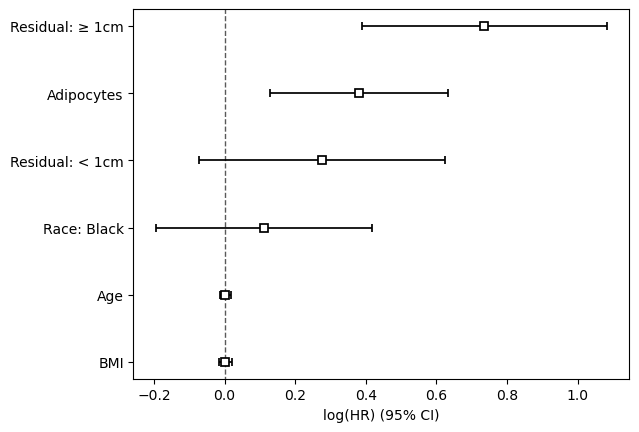

In [104]:
# ------------------------------ fit penalised CoxPH ------------------------------
cph = CoxPHFitter()

cph.fit(
    cox_df,
    show_progress=True,
    strata="Stage",
    duration_col="Time-Days",
    event_col="Event",
)

cph.print_summary(columns=["coef", "exp(coef)", "p", "z"])

cph.plot()

cph.check_assumptions(cox_df, p_value_threshold=0.05, show_plots=False)

In [105]:
if complete_case:
    title_for_plot = f"Restricted Model (n={cox_df.shape[0]})"
else:
    title_for_plot = f"Main Model (n={cox_df.shape[0]})"

In [106]:
summary_small = (
    cph.summary[["exp(coef)", "p"]]
    .rename(columns={"exp(coef)": "HazardRatio", "p": "P-Value"})
    .reset_index()  # moves the index into a column
    .rename(columns={"covariate": "Covariate"})  # give that column a nicer name
)
summary_small["Model"] = title_for_plot

new_order = ["Model"] + [c for c in summary_small.columns if c != "Model"]
summary_small = summary_small[new_order]
# take a look
display(summary_small.style.hide(axis="index"))
summary_small.to_clipboard(index=False, excel=True)

Model,Covariate,HazardRatio,P-Value
Restricted Model (n=287),Age,1.002447,0.742009
Restricted Model (n=287),BMI,1.001883,0.839361
Restricted Model (n=287),Residual: < 1cm,1.318400,0.120342
Restricted Model (n=287),Residual: ≥ 1cm,2.086100,0.000033
Restricted Model (n=287),Race: Black,1.118259,0.473721
Restricted Model (n=287),Adipocytes,1.463465,0.003196


In [107]:
# Full table
cph.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
Age,0.002444,1.002447,0.007424,-0.012106,0.016994,0.987967,1.017139,0.0,0.329194,0.742009,0.430492
BMI,0.001882,1.001883,0.009282,-0.016311,0.020075,0.983821,1.020278,0.0,0.202711,0.839361,0.252637
Residual: < 1cm,0.276419,1.318400,0.177951,-0.072359,0.625197,0.930197,1.868614,0.0,1.553339,0.120342,3.054787
Residual: ≥ 1cm,0.735296,2.086100,0.177137,0.388114,1.082479,1.474198,2.951987,0.0,4.151000,0.000033,14.882698
Race: Black,0.111773,1.118259,0.156012,-0.194005,0.417551,0.823654,1.518240,0.0,0.716438,0.473721,1.077891
Adipocytes,0.380807,1.463465,0.129166,0.127646,0.633967,1.136151,1.885074,0.0,2.948199,0.003196,8.289377


In [108]:
# Full table
dataframe_to_save = cph.summary.copy()
title = "Main Model" if not complete_case else "Restricted Model"
dataframe_to_save["model"] = title
save_path = f"{os.getcwd()}/../results/coxph_summary_{cell_types_to_use[0]}_{title.replace(' ','_')}.csv"
dataframe_to_save.to_csv(save_path)

In [109]:
# Full table
dataframe_to_save = cph.summary.copy()
title = "Main Model" if not complete_case else "Restricted Model"
dataframe_to_save["model"] = title
save_path = f"{os.getcwd()}/../results/coxph_summary_{cell_types_to_use[0]}_{title.replace(' ','_')}.csv"
dataframe_to_save.to_csv(save_path)

title_to_open = "Main Model" if complete_case else "Restricted Model"
save_path = f"{os.getcwd()}/../results/coxph_summary_{cell_types_to_use[0]}_{title_to_open.replace(' ','_')}.csv"
other_model = pd.read_csv(save_path, index_col=0)
results = pd.concat([other_model,dataframe_to_save])
results

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p),model
covariate,,,,,,,,,,,,
Age,0.011762,1.011831,0.005040,0.001884,0.021639,1.001886,1.021875,0.0,2.333736,0.019610,5.672299,Main Model
BMI,0.006108,1.006127,0.006576,-0.006780,0.018997,0.993243,1.019178,0.0,0.928932,0.352924,1.502569,Main Model
Race: Black,0.022988,1.023254,0.102714,-0.178327,0.224303,0.836669,1.251450,0.0,0.223808,0.822907,0.281199,Main Model
Adipocytes,0.349070,1.417748,0.094389,0.164070,0.534069,1.178297,1.705860,0.0,3.698190,0.000217,12.169070,Main Model
Age,0.002444,1.002447,0.007424,-0.012106,0.016994,0.987967,1.017139,0.0,0.329194,0.742009,0.430492,Restricted Model
BMI,0.001882,1.001883,0.009282,-0.016311,0.020075,0.983821,1.020278,0.0,0.202711,0.839361,0.252637,Restricted Model
Residual: < 1cm,0.276419,1.318400,0.177951,-0.072359,0.625197,0.930197,1.868614,0.0,1.553339,0.120342,3.054787,Restricted Model
Residual: ≥ 1cm,0.735296,2.086100,0.177137,0.388114,1.082479,1.474198,2.951987,0.0,4.151000,0.000033,14.882698,Restricted Model
Race: Black,0.111773,1.118259,0.156012,-0.194005,0.417551,0.823654,1.518240,0.0,0.716438,0.473721,1.077891,Restricted Model


In [110]:
summ_cop = cph.summary.copy()
summ =results.loc[cell_types_to_use[0]]
col = summ["model"]
summ.index = col.values
summ

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p),model
Main Model,0.349070,1.417748,0.094389,0.164070,0.534069,1.178297,1.705860,0.0,3.698190,0.000217,12.169070,Main Model
Restricted Model,0.380807,1.463465,0.129166,0.127646,0.633967,1.136151,1.885074,0.0,2.948199,0.003196,8.289377,Restricted Model


In [111]:
from matplotlib.ticker import LogLocator, NullLocator, NullFormatter, FuncFormatter


/var/folders/d3/x10lxf7x1n37__s3n36qxmlw0000gp/T/ipykernel_64761/2263269463.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summ["HR"] = np.exp(summ["coef"])
/var/folders/d3/x10lxf7x1n37__s3n36qxmlw0000gp/T/ipykernel_64761/2263269463.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summ["lower95"] = np.exp(summ[ci_lower_col])
/var/folders/d3/x10lxf7x1n37__s3n36qxmlw0000gp/T/ipykernel_64761/2263269463.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


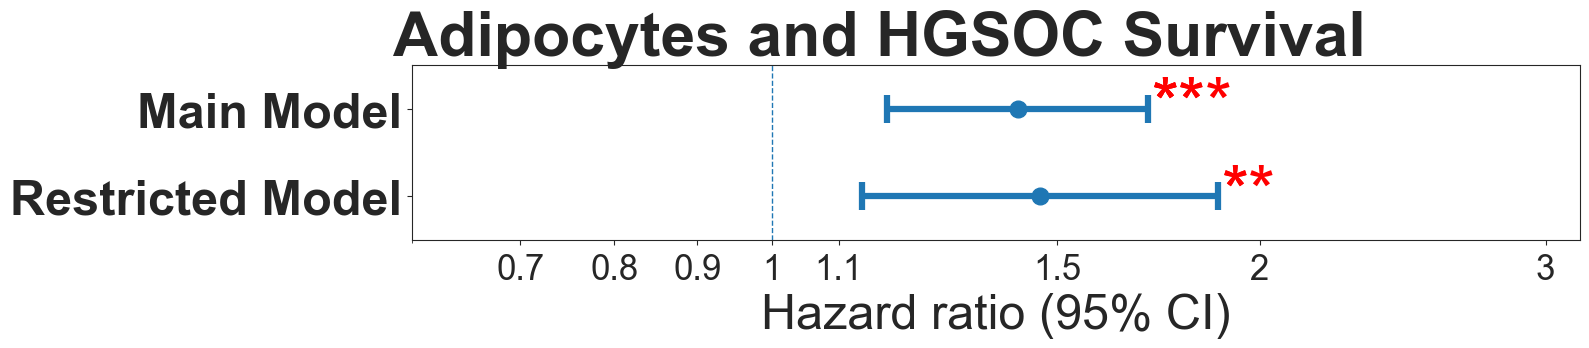

In [112]:
# ------------------------------------------------------------------
# 1. Pull the numbers we need on the *log(HR)* scale (Cox β)
# ------------------------------------------------------------------
sns.set_style("ticks", {"xtick.major.size": 5, "ytick.major.size": 5})

# Locate the 95% CI columns, version-agnostic
ci_lower_col = [c for c in summ.columns if c.startswith("coef lower")][0]
ci_upper_col = [c for c in summ.columns if c.startswith("coef upper")][0]

# Work directly on the log scale (β = log(HR))
summ["HR"] = np.exp(summ["coef"])
summ["lower95"] = np.exp(summ[ci_lower_col])
summ["upper95"] = np.exp(summ[ci_upper_col])

# ------------------------------------------------------------------
# 2. Plot on a linear x-axis whose units are log(HR)
# ------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(16, 1.8 * len(summ)))
ypos = np.arange(len(summ))

ax.errorbar(
    x=summ["HR"],
    y=ypos,
    xerr=[summ["HR"] - summ["lower95"], summ["upper95"] - summ["HR"]],
    fmt="o",
    capsize=10,
    linewidth=4.5,
    elinewidth=4.5,
    capthick=4.5,
    markersize=12,
)

# Stars for p-values (unchanged; positioned just to the right of the CI)
for i, p in enumerate(summ["p"]):
    if p < 0.05:
        ax.text(summ["upper95"].iloc[i] + 0.01, ypos[i], "*", va="center", fontsize=50, color="red")
    if p < 0.005:
        ax.text(summ["upper95"].iloc[i] + 0.01, ypos[i], "**", va="center", fontsize=50, color="red")
    if p < 0.0005:
        ax.text(summ["upper95"].iloc[i] + 0.01, ypos[i], "***", va="center", fontsize=50, color="red")
padding = 0.5 
ax.set_ylim(-padding, len(summ) - 1 + padding)
ax.set_xscale("log")
ax.set_yticks(ypos)
ax.tick_params(axis='x', labelsize=25)
ax.set_yticklabels(summ.index, fontsize=35, fontweight="bold")
ax.set_ylabel("", fontsize=35)
ax.set_xlabel("Hazard ratio (95% CI)", fontsize=35)
cell_name = cell_types_to_use[0] if cell_types_to_use[0] == "Adipocytes" else cell_types_to_use[0]+" Cells"
ax.set_title(f"{cell_name} and HGSOC Survival", fontsize=45, fontweight="bold", y=1.01, x=0.4)

from matplotlib.ticker import FixedLocator, FuncFormatter, LogLocator, NullFormatter

# 1) Fixed limits for all figures
ax.set_xscale("log")
ax.set_xlim(0.6, 3.15)

# 2) Fixed major tick *values* (same everywhere)
fixed_ticks = [0.7, 0.8, 0.9, 1.0, 1.1, 1.5,2.0, 3.0]
ax.xaxis.set_major_locator(FixedLocator(fixed_ticks))

# 3) Plain decimal labels (no 10^x, no 1e-01), tidy zeros
def plain_fmt(x, pos):
    if x < 1:
        s = f"{x:.2f}"
    elif x < 10:
        s = f"{x:.1f}"
    else:
        s = f"{x:g}"
    return s.rstrip("0").rstrip(".")
ax.xaxis.set_major_formatter(FuncFormatter(plain_fmt))

# 4) Optional: minor tick marks only (no labels), for log “feel”
ax.xaxis.set_minor_locator(LogLocator(base=10, subs=(2,3,4,5,6,7,8,9)))
ax.xaxis.set_minor_formatter(NullFormatter())

# 5) Styling (adjust size if they feel tight)
ax.tick_params(axis="x", which="major", labelsize=22, pad=6)

# 4) styling
ax.tick_params(axis='x', which='major', labelsize=25)
ax.axvline(1, ls="--", lw=1)
ax.invert_yaxis()
plt.tight_layout()
plt.show()

In [113]:
print("xlim:", ax.get_xlim())


xlim: (np.float64(0.6), np.float64(3.15))


* **HR > 1** → Higher covariate value is associated with **shorter** survival.  
* **HR < 1** → Higher covariate value is associated with **longer** survival.

/Users/ivicha/anaconda3/envs/env_deconv/lib/python3.10/site-packages/matplotlib/cbook.py:1719: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)
/Users/ivicha/Documents/HGSOC_Adipocytes/notebooks/../src/hp.py:82: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


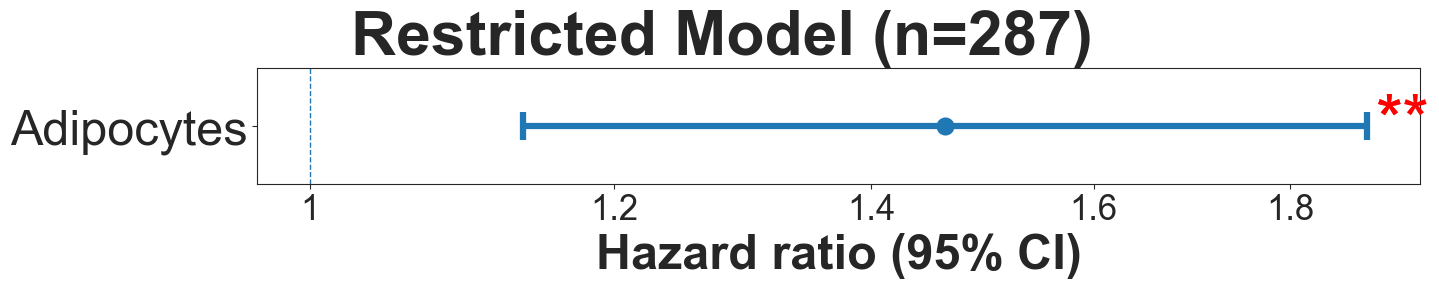

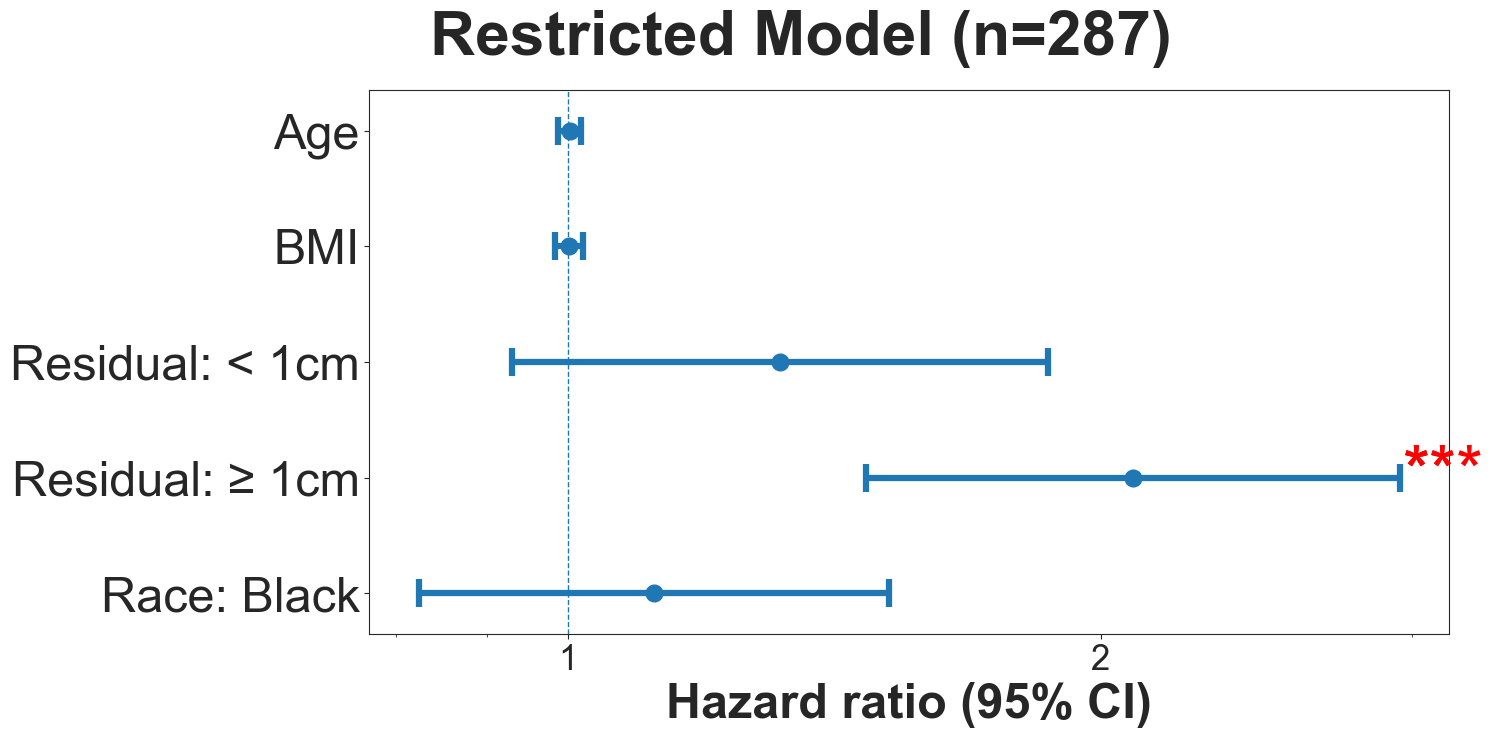

In [114]:
extras = [v for v in summ_cop.index if v not in cell_types_to_use]
summ_cop["HR"] = np.exp(summ_cop["coef"])
summ_cop["lower95"] = np.exp(summ_cop[ci_lower_col])
summ_cop["upper95"] = np.exp(summ_cop[ci_upper_col])

hp.plot_forest_subset(
    summ_cop,
    variables=cell_types_to_use,
    title=f"{title_for_plot}",
)

hp.plot_forest_subset(
    summ_cop,
    variables=extras,
    title=f"{title_for_plot}",
)